In [1]:
import foldable_robotics.dxf as frd
import foldable_robotics as fr
import foldable_robotics.manufacturing as frm
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.parts.castellated_hinge2 as frc
import shapely.geometry as sg

In [2]:
fr.display_height=300
fr.resolution = 4
desired_degrees = 120
thickness = 1
plain_width = frm.plain_hinge_width(desired_degrees,thickness)
plain_width

1.7320508075688774

In [3]:
support_width = 2 # must be larger than hinge width
kerf = .05
is_adhesive = [False,True,False,True,False]
arc_approx = 10
NUM_LAYERS = 5
bridge_thickness = 2
bounding_box_padding = 10
jig_spacing = 10
jig_dia = 5

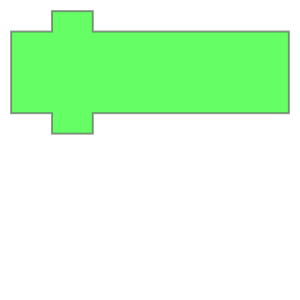

In [4]:
# Reading body vertices
body_vertices = frd.read_lwpolylines(
    'Bipedal1.dxf',
    layer='body',
    arc_approx=arc_approx
)
body_polygons = [sg.Polygon(item) for item in body_vertices]
body_layer = Layer(*body_polygons)
body_layer

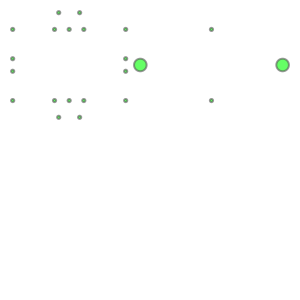

In [5]:
# Reading hole vertices
hole_vertices = frd.read_circles('Bipedal1.dxf',  layer='holes')
hole_layer = Layer(*[sg.Point(center).buffer(radius) for center, radius in hole_vertices])
# hole_layer = Layer(*[sg.Polygon(item) for item in hole_vertices])
hole_layer

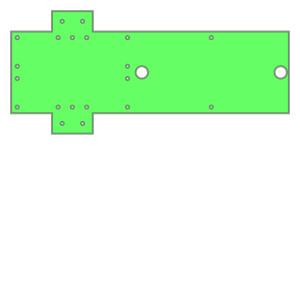

In [6]:
# Subtracting the holes from the body layer
body_layer -= hole_layer
body_layer

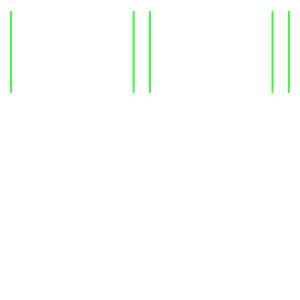

In [7]:
# Reading joint vertices
joint_vertices = frd.read_lines('Bipedal1.dxf', layer='joints')
joint_lines_original_layer = Layer(*[sg.LineString(item) for item in joint_vertices])
joint_lines_original_layer

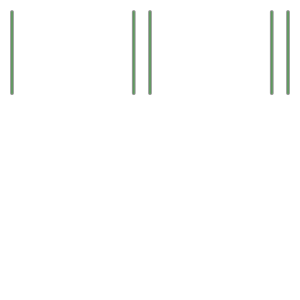

In [8]:
joint_lines_modified_layer = joint_lines_original_layer & body_layer
modified_joint_vertices = [list(item.coords) for item in joint_lines_modified_layer.geoms]
simple_joint_layer = joint_lines_modified_layer << plain_width/2
simple_joint_layer

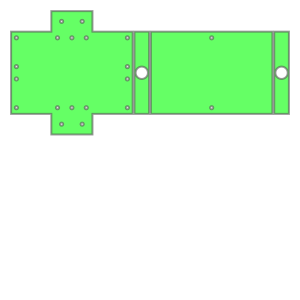

In [9]:
rigid_layer = (body_layer - simple_joint_layer)
rigid_layer

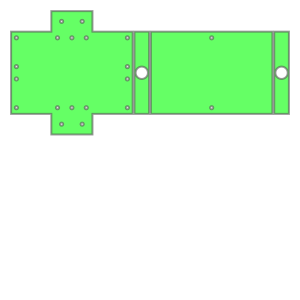

In [10]:
adhesive_layer = rigid_layer & body_layer
adhesive_layer

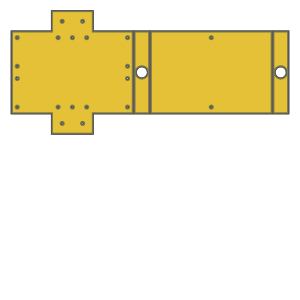

In [11]:
ideal_final_device = Laminate(rigid_layer,adhesive_layer, body_layer,
adhesive_layer,rigid_layer)
ideal_final_device

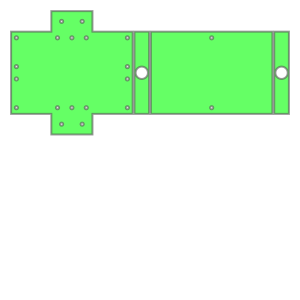

In [12]:
# Rigid Layer 
ideal_final_device[0]

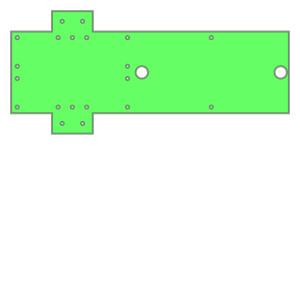

In [13]:
# Adhesive Layer 
ideal_final_device[2]

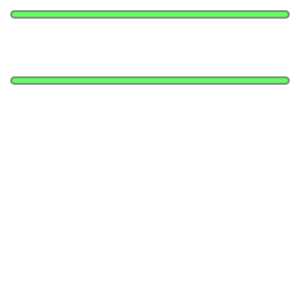

In [14]:
bridges = frd.read_lwpolylines('Bipedal1.dxf', layer='bridges')
bridges
bridges_layer = Layer(*[sg.LineString(item) for item in bridges])
bridges_layer <<= bridge_thickness
bridges_layer

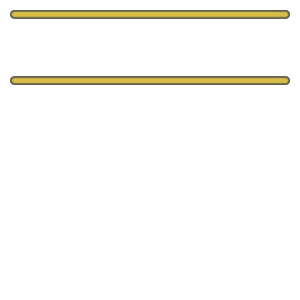

In [15]:
bridges_lam = Laminate(bridges_layer,bridges_layer,Layer(),bridges_layer,bridges_layer)
bridges_lam

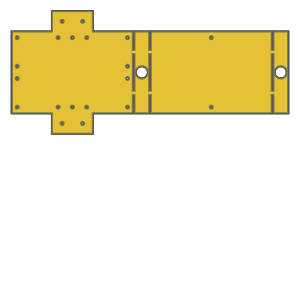

In [16]:
supported_actual_device = ideal_final_device | bridges_lam
supported_actual_device

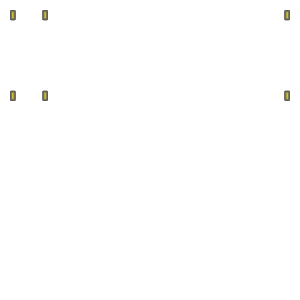

In [17]:
diff = supported_actual_device - ideal_final_device
removal = frm.cleanup(diff, .1)
removal

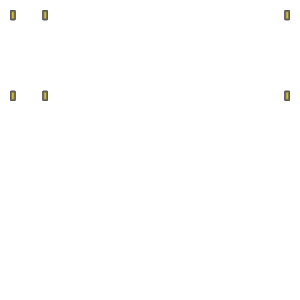

In [18]:
removal = frm.keepout_laser(removal)
removal

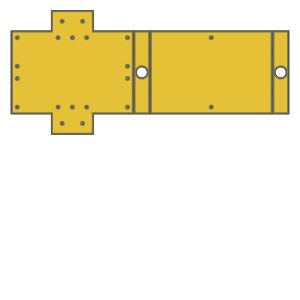

In [19]:
actual_final_device = ideal_final_device - removal
actual_final_device

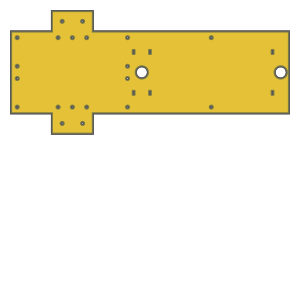

In [20]:
keepout = frm.keepout_laser(actual_final_device)
keepout

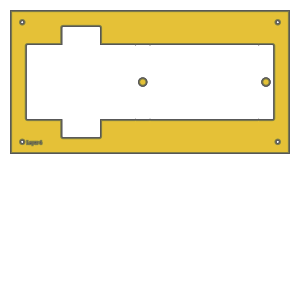

In [21]:
layer_id = frm.build_layer_numbers(NUM_LAYERS,text_size=jig_dia)
layer_id = layer_id.simplify(.2)
(x1,y1),(x2,y2) = actual_final_device.bounding_box_coords()
w1,h1 = actual_final_device.get_dimensions()
w2 = round(w1/jig_spacing)*jig_spacing+jig_spacing+support_width
h2 = round(h1/jig_spacing)*jig_spacing+jig_spacing+support_width
x1 -= (w2-w1)/2
y1 -= (h2-h1)/2
x2 += (w2-w1)/2
y2 += (h2-h1)/2
points = []
points.append(sg.Point(x1,y1))
points.append(sg.Point(x2,y1))
points.append(sg.Point(x1,y2))
points.append(sg.Point(x2,y2))
alignment_holes_layer = Layer(*points)
alignment_holes_layer<<=(jig_dia/2)
alignment_holes=alignment_holes_layer.to_laminate(NUM_LAYERS)

sheet_layer = (alignment_holes_layer<<bounding_box_padding).bounding_box()
sheet=sheet_layer.to_laminate(NUM_LAYERS)
sheet

removable_scrap = frm.calculate_removable_scrap(actual_final_device,sheet,support_width,is_adhesive)
web = removable_scrap-alignment_holes-layer_id.translate(x1+jig_dia,y1-jig_dia/2)
web

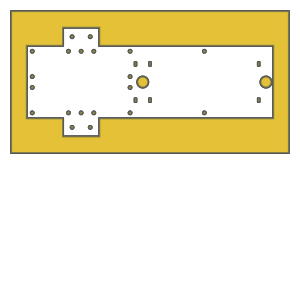

In [22]:
second_pass_scrap = sheet-keepout
second_pass_scrap

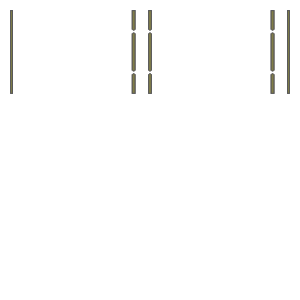

In [23]:
first_pass_scrap = sheet - second_pass_scrap - actual_final_device
first_pass_scrap = frm.cleanup(first_pass_scrap,.00001)
first_pass_scrap

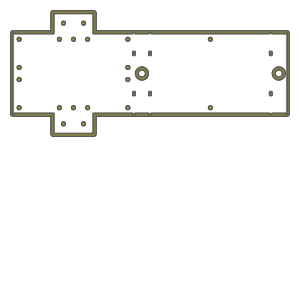

In [24]:
support = frm.support(actual_final_device,frm.keepout_laser,support_width,support_width/2)
support

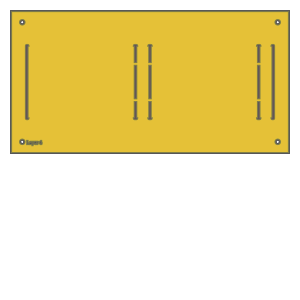

In [25]:
supported_design = web|actual_final_device|support| bridges_lam
supported_design

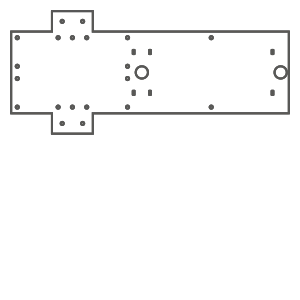

In [26]:
cut_material = (keepout<<kerf)-keepout
cut_material

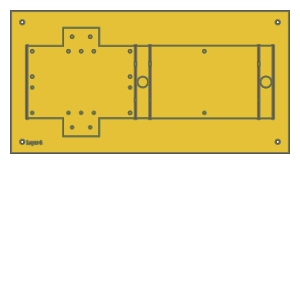

In [27]:
remaining_material = supported_design-cut_material
remaining_material

In [28]:
remaining_parts = frm.find_connected(remaining_material,is_adhesive)

In [ ]:
test_part=actual_final_device>>1
for result in remaining_parts:
    if not (result&test_part).is_null():
        break
result

In [ ]:
check = (result^actual_final_device)
check>>=1e-1
assert(check.is_null())

In [ ]:
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()
rigid_layer = supported_design[0] | (supported_design[-1].translate(w+5,0))
rigid_layer

In [ ]:
l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+w+5,p0[1]-p2[1])
adhesive_layer = supported_design[1] | l4
adhesive_layer

In [ ]:
first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])
first_pass.export_dxf('bp_firstpass')

In [ ]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.export_dxf('bp_final_cut')
final_cut